# Hypothesis 4: User-Level Analysis
- Define oldbie and newbie users

In [41]:
# Import Modules
import pandas as pd
import numpy as np
import sqlite3
import pickle
import os
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
# Import Dataset
conn = sqlite3.connect('/data1/StackOverflow/stackexchange-to-sqlite/stack.db')
query = '''
SELECT id, creation_date, owner_user_id
FROM questions
WHERE creation_date > '2021-09-01'
AND creation_date < '2023-09-01';
'''
df = pd.read_sql_query(query, conn)
conn.close()

In [42]:
# Import Users Data
conn = sqlite3.connect('/data1/StackOverflow/stackexchange-to-sqlite/stack.db')
query = '''
SELECT id, creation_date
FROM users;
'''
user_df = pd.read_sql_query(query, conn)
conn.close()

In [25]:
df

,id,creation_date,owner_user_id
0,69006423,2021-09-01 00:00:35.237,14087917.0
1,69006426,2021-09-01 00:00:55.583,13091928.0
2,69006431,2021-09-01 00:01:23.670,8110267.0
3,69006437,2021-09-01 00:03:18.750,2745485.0
4,69006439,2021-09-01 00:03:36.930,12139975.0
...,...,...,...
2715204,77019848,2023-08-31 23:54:30.057,1006272.0
2715205,77019849,2023-08-31 23:55:21.660,15216800.0
2715206,77019852,2023-08-31 23:56:42.653,433202.0
2715207,77019854,2023-08-31 23:57:28.633,2532775.0


In [43]:
user_df = user_df.rename(columns = {'creation_date':'account_creation_date',
                                    'id': 'owner_user_id'})

In [44]:
df = df.dropna(subset=['owner_user_id'])
df['owner_user_id'] = df['owner_user_id'].astype(int).astype(str)
user_df['owner_user_id'] = user_df.owner_user_id.astype(str)

In [45]:
df_merge = pd.merge(df, user_df, on = 'owner_user_id', how = 'left')
df_merge

,id,creation_date,owner_user_id,account_creation_date
0,69006423,2021-09-01 00:00:35.237,14087917,2020-08-11 15:14:12.437
1,69006426,2021-09-01 00:00:55.583,13091928,2020-03-20 01:17:22.550
2,69006431,2021-09-01 00:01:23.670,8110267,2017-06-04 12:15:02.013
3,69006437,2021-09-01 00:03:18.750,2745485,2013-09-04 06:00:02.613
4,69006439,2021-09-01 00:03:36.930,12139975,2019-09-29 20:57:59.120
...,...,...,...,...
2682915,77019848,2023-08-31 23:54:30.057,1006272,2011-10-21 00:44:45.587
2682916,77019849,2023-08-31 23:55:21.660,15216800,2021-02-15 22:29:56.837
2682917,77019852,2023-08-31 23:56:42.653,433202,2010-08-27 17:36:47.873
2682918,77019854,2023-08-31 23:57:28.633,2532775,2013-06-28 17:18:15.807


In [46]:
# Compute difference between post creation_date - user creation_date.
df_merge['month_diff'] = (pd.to_datetime(df_merge['creation_date']) - pd.to_datetime(df_merge['account_creation_date'])) / pd.Timedelta(days=30)

In [47]:
df_merge['year_month'] = pd.to_datetime(df_merge['creation_date']).dt.to_period('M') # Monthly
df_merge

,id,creation_date,owner_user_id,account_creation_date,month_diff,year_month
0,69006423,2021-09-01 00:00:35.237,14087917,2020-08-11 15:14:12.437,12.845518,2021-09
1,69006426,2021-09-01 00:00:55.583,13091928,2020-03-20 01:17:22.550,17.664897,2021-09
2,69006431,2021-09-01 00:01:23.670,8110267,2017-06-04 12:15:02.013,51.649684,2021-09
3,69006437,2021-09-01 00:03:18.750,2745485,2013-09-04 06:00:02.613,97.291742,2021-09
4,69006439,2021-09-01 00:03:36.930,12139975,2019-09-29 20:57:59.120,23.404297,2021-09
...,...,...,...,...,...,...
2682915,77019848,2023-08-31 23:54:30.057,1006272,2011-10-21 00:44:45.587,144.432170,2023-08
2682916,77019849,2023-08-31 23:55:21.660,15216800,2021-02-15 22:29:56.837,30.901977,2023-08
2682917,77019852,2023-08-31 23:56:42.653,433202,2010-08-27 17:36:47.873,158.408794,2023-08
2682918,77019854,2023-08-31 23:57:28.633,2532775,2013-06-28 17:18:15.807,123.875908,2023-08


### Wrong data (user creation date is earlier than post creation date)

In [48]:
# There are some negative values in the raw data.
df_merge[df_merge['month_diff'] <= 0]

,id,creation_date,owner_user_id,account_creation_date,month_diff,year_month
5900,69026674,2021-09-02 08:25:33.403,17450994,2021-11-18 20:12:17.750,-2.583026,2021-09
57314,69197834,2021-09-15 17:55:30.727,17450994,2021-11-18 20:12:17.750,-2.136500,2021-09
137933,69464705,2021-09-11 10:08:01.420,17142767,2021-10-13 12:38:18.520,-1.070145,2021-09
138640,69467111,2021-10-06 13:40:32.650,17090949,2021-10-06 15:47:08.750,-0.002931,2021-10
174934,69587843,2021-10-15 15:31:26.067,17165773,2021-10-16 05:34:53.577,-0.019525,2021-10
...,...,...,...,...,...,...
2635869,76912946,2023-08-16 01:59:48.140,22407721,2023-08-17 23:13:27.293,-0.062816,2023-08
2637560,76916944,2023-08-16 19:49:14.903,22401730,2023-08-16 21:27:23.667,-0.002272,2023-08
2640202,76923267,2023-07-17 05:13:05.937,22250711,2023-07-19 07:14:01.470,-0.069466,2023-07
2663195,76977497,2023-08-25 12:52:38.617,22446908,2023-08-25 13:22:31.713,-0.000692,2023-08


In [34]:
df_merge.describe()

,id,month_diff
count,2.682920e+06,2.682916e+06
mean,7.323562e+07,4.215223e+01
std,2.333616e+06,4.527058e+01
min,6.900642e+07,-2.096422e+01
25%,7.121449e+07,2.511565e+00
50%,7.340831e+07,2.419193e+01
75%,7.526984e+07,7.318636e+01
max,7.701986e+07,1.834103e+02


### Descriptive Statistics and Visualization

In [49]:
# Descriptive Statistics for each month
stats = df_merge.groupby("year_month").agg({"month_diff": ["mean", "std", "min",lambda x: x.quantile(0.25), lambda x: x.quantile(0.5), lambda x: x.quantile(0.75), "max"]}).reset_index()
# Extracting the median (quantile 0.5) values for visualization
stats.columns = ['year_month', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
stats

,year_month,mean,std,min,25%,50%,75%,max
0,2021-09,39.083714,41.582313,-2.583026,2.869898,22.471427,67.292179,160.069253
1,2021-10,39.448573,42.055997,-3.961058,2.701094,22.461776,68.402981,161.012606
2,2021-11,39.075923,42.065644,-20.964221,2.402762,21.734819,67.567541,162.060801
3,2021-12,39.005337,42.137213,-15.515772,2.383288,21.576312,67.334073,162.815341
4,2022-01,40.256464,42.768756,-12.164283,2.921805,22.788431,69.775513,164.149880
5,2022-02,40.441018,43.129156,-0.069656,2.792054,23.035460,70.377897,165.035159
6,2022-03,40.044867,43.071649,-6.802711,2.557232,22.982073,69.404366,166.318841
7,2022-04,39.094343,43.060068,-6.233250,2.080229,21.663680,67.032588,167.128731
8,2022-05,39.551794,43.443221,-8.474859,2.134294,21.802347,67.726039,168.213863
9,2022-06,40.151996,43.749941,-7.515943,2.265405,22.590830,69.320929,169.288366


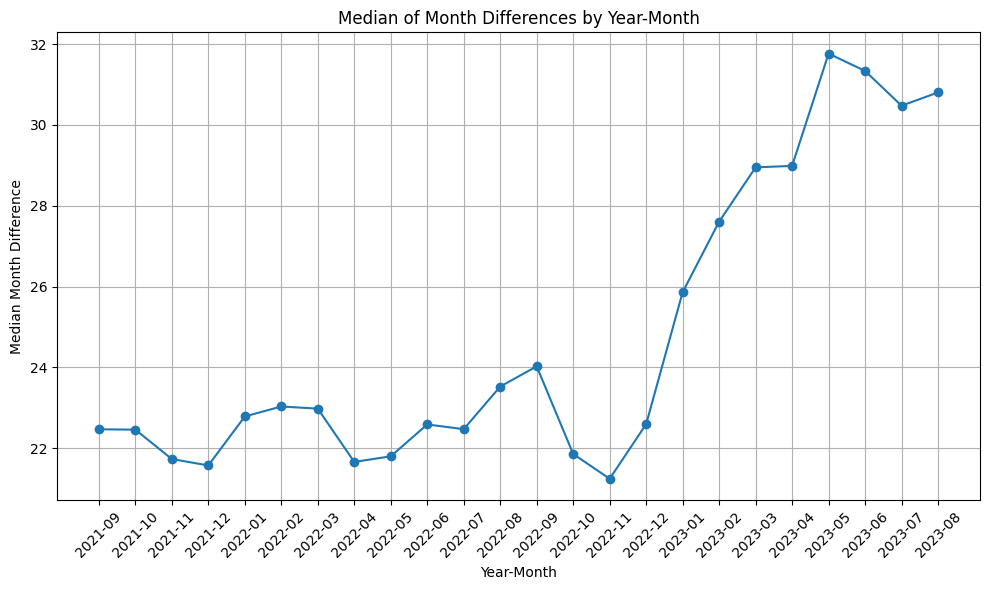

In [43]:
# Visualization of median value by each month.
plt.figure(figsize=(10, 6))
plt.plot(stats['year_month'].astype(str), stats['50%'], marker='o', linestyle='-')
plt.title('Median of Month Differences by Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Median Month Difference')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

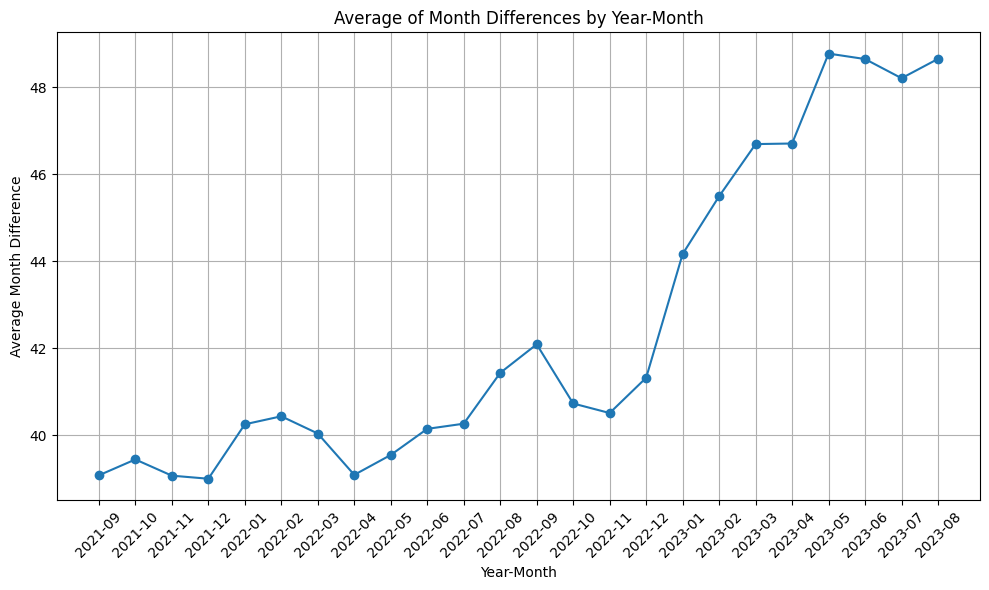

In [45]:
# Visualization of median value by each month.
plt.figure(figsize=(10, 6))
plt.plot(stats['year_month'].astype(str), stats['mean'], marker='o', linestyle='-')
plt.title('Average of Month Differences by Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Average Month Difference')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

### Define isNew variable

In [50]:
# set threshold as 12 months. (1 year)
df_merge['isNew'] = df_merge['month_diff'].apply(lambda x: 1 if x <= 12 else 0)
df_merge

,id,creation_date,owner_user_id,account_creation_date,month_diff,year_month,isNew
0,69006423,2021-09-01 00:00:35.237,14087917,2020-08-11 15:14:12.437,12.845518,2021-09,0
1,69006426,2021-09-01 00:00:55.583,13091928,2020-03-20 01:17:22.550,17.664897,2021-09,0
2,69006431,2021-09-01 00:01:23.670,8110267,2017-06-04 12:15:02.013,51.649684,2021-09,0
3,69006437,2021-09-01 00:03:18.750,2745485,2013-09-04 06:00:02.613,97.291742,2021-09,0
4,69006439,2021-09-01 00:03:36.930,12139975,2019-09-29 20:57:59.120,23.404297,2021-09,0
...,...,...,...,...,...,...,...
2682915,77019848,2023-08-31 23:54:30.057,1006272,2011-10-21 00:44:45.587,144.432170,2023-08,0
2682916,77019849,2023-08-31 23:55:21.660,15216800,2021-02-15 22:29:56.837,30.901977,2023-08,0
2682917,77019852,2023-08-31 23:56:42.653,433202,2010-08-27 17:36:47.873,158.408794,2023-08,0
2682918,77019854,2023-08-31 23:57:28.633,2532775,2013-06-28 17:18:15.807,123.875908,2023-08,0


In [51]:
df_analysis = pd.merge(df_merge.groupby('year_month')['id'].count().reset_index(), df_merge.groupby('year_month')['isNew'].sum().reset_index(), on = 'year_month')
df_analysis.columns = ['year_month', 'TotalCount', 'NewCount']
df_analysis['newPercentage'] = df_analysis['NewCount'] / df_analysis['TotalCount'] * 100
df_analysis

,year_month,TotalCount,NewCount,newPercentage
0,2021-09,118552,46704,39.395371
1,2021-10,117679,46406,39.434394
2,2021-11,118247,47242,39.951965
3,2021-12,111393,44432,39.887605
4,2022-01,118686,45892,38.666734
5,2022-02,113318,44331,39.120881
6,2022-03,123009,48310,39.273549
7,2022-04,114109,46216,40.501626
8,2022-05,116271,46863,40.304977
9,2022-06,111731,44593,39.911036


In [88]:
(df_analysis['NewCount'] / df_analysis['TotalCount']).mean()

0.38573697020225106

/tmp/ipykernel_1891646/2646781211.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(plt.FixedFormatter(df_analysis['year_month'].dt.strftime('%Y-%m')))


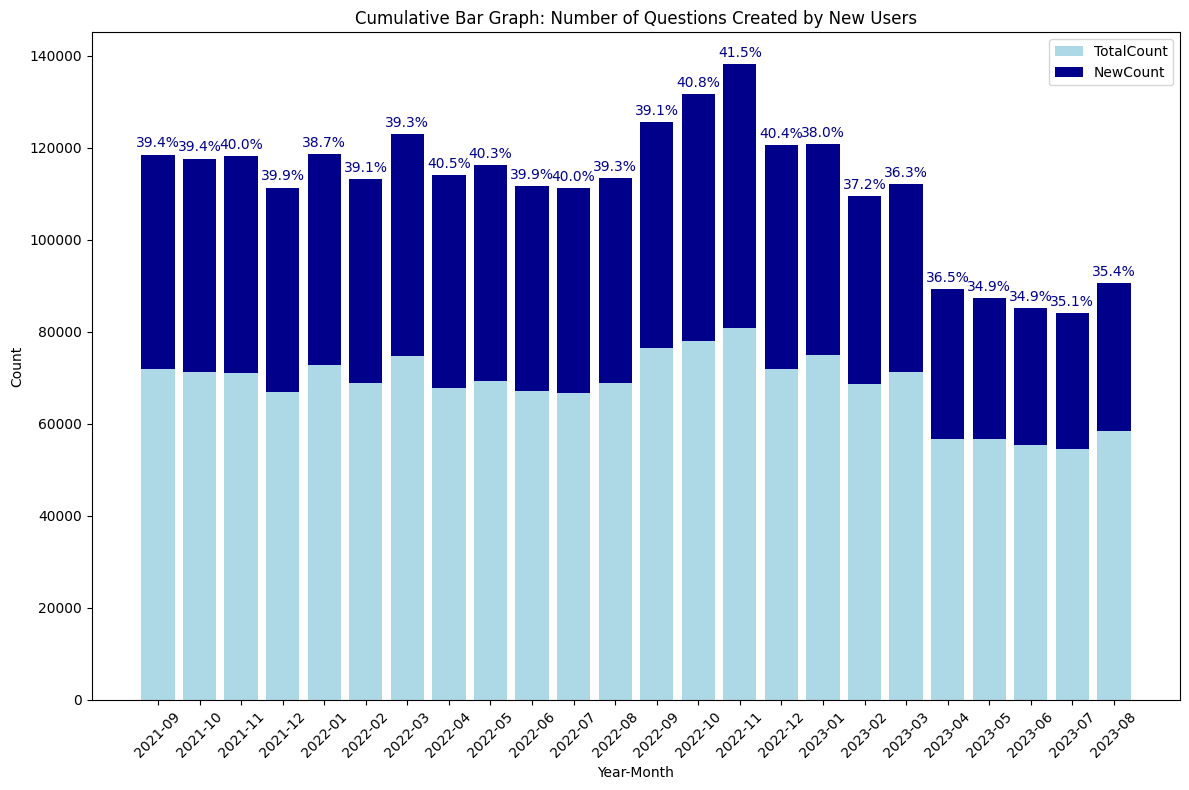

In [52]:
# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the TotalCount
bars_total = ax.bar(df_analysis['year_month'].astype(str), df_analysis['TotalCount'], label='TotalCount', color='lightblue')

# Plot the NewCount on top of TotalCount to show cumulative effect
bars_new = ax.bar(df_analysis['year_month'].astype(str), df_analysis['NewCount'], bottom=df_analysis['TotalCount'] - df_analysis['NewCount'], label='NewCount', color='darkblue')

# Adding labels and title
ax.set_xlabel('Year-Month')
ax.set_ylabel('Count')
ax.set_title('Cumulative Bar Graph: Number of Questions Created by New Users') # Number of Posts Created by New Users
ax.legend()

# Formatting the x-axis for better readability
ax.xaxis.set_major_formatter(plt.FixedFormatter(df_analysis['year_month'].dt.strftime('%Y-%m')))

# Add percentage annotations
for bar_new, new_percentage in zip(bars_new, df_analysis['newPercentage']):
    height_new = bar_new.get_height() + bar_new.get_y()
    
    ax.annotate(f'{new_percentage:.1f}%', 
                xy=(bar_new.get_x() + bar_new.get_width() / 2, height_new),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', color='darkblue', fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Analysis

In [100]:
df_merge

,id,creation_date,owner_user_id,account_creation_date,month_diff,year_month,isNew
0,69006423,2021-09-01 00:00:35.237,14087917,2020-08-11 15:14:12.437,12.845518,2021-09,0
1,69006426,2021-09-01 00:00:55.583,13091928,2020-03-20 01:17:22.550,17.664897,2021-09,0
2,69006431,2021-09-01 00:01:23.670,8110267,2017-06-04 12:15:02.013,51.649684,2021-09,0
3,69006437,2021-09-01 00:03:18.750,2745485,2013-09-04 06:00:02.613,97.291742,2021-09,0
4,69006439,2021-09-01 00:03:36.930,12139975,2019-09-29 20:57:59.120,23.404297,2021-09,0
...,...,...,...,...,...,...,...
2682915,77019848,2023-08-31 23:54:30.057,1006272,2011-10-21 00:44:45.587,144.432170,2023-08,0
2682916,77019849,2023-08-31 23:55:21.660,15216800,2021-02-15 22:29:56.837,30.901977,2023-08,0
2682917,77019852,2023-08-31 23:56:42.653,433202,2010-08-27 17:36:47.873,158.408794,2023-08,0
2682918,77019854,2023-08-31 23:57:28.633,2532775,2013-06-28 17:18:15.807,123.875908,2023-08,0


In [53]:
user_df['year_month'] = pd.to_datetime(user_df['account_creation_date']).dt.to_period('M') # Monthly
user_df

,owner_user_id,account_creation_date,year_month
0,-1016,2023-06-28 20:22:59.967,2023-06
1,-1015,2023-06-28 18:50:43.493,2023-06
2,-1014,2023-02-17 19:52:56.213,2023-02
3,-1013,2023-02-17 19:25:19.953,2023-02
4,-1012,2023-02-15 23:24:13.363,2023-02
...,...,...,...
21077275,22492432,2023-09-03 11:44:44.337,2023-09
21077276,22492433,2023-09-03 11:44:49.580,2023-09
21077277,22492434,2023-09-03 11:44:57.507,2023-09
21077278,22492435,2023-09-03 11:45:03.880,2023-09


In [67]:
user_df['year'] = pd.to_datetime(user_df['account_creation_date']).dt.to_period('Y') # Monthly

In [69]:
NumNewUser = user_df.groupby('year').count().reset_index()
NumNewUser

,year,owner_user_id,account_creation_date,year_month
0,2008,21629,21629,21629
1,2009,77934,77934,77934
2,2010,199067,199067,199067
3,2011,358422,358422,358422
4,2012,678195,678195,678195
5,2013,1121247,1121247,1121247
6,2014,1173259,1173259,1173259
7,2015,1250621,1250621,1250621
8,2016,1513202,1513202,1513202
9,2017,1723693,1723693,1723693


In [64]:
NumNewUser.iloc[146:-1,:]

,year_month,owner_user_id,account_creation_date
146,2020-09,167583,167583
147,2020-10,181722,181722
148,2020-11,178547,178547
149,2020-12,178491,178491
150,2021-01,194662,194662
151,2021-02,180672,180672
152,2021-03,217285,217285
153,2021-04,230365,230365
154,2021-05,281317,281317
155,2021-06,260406,260406


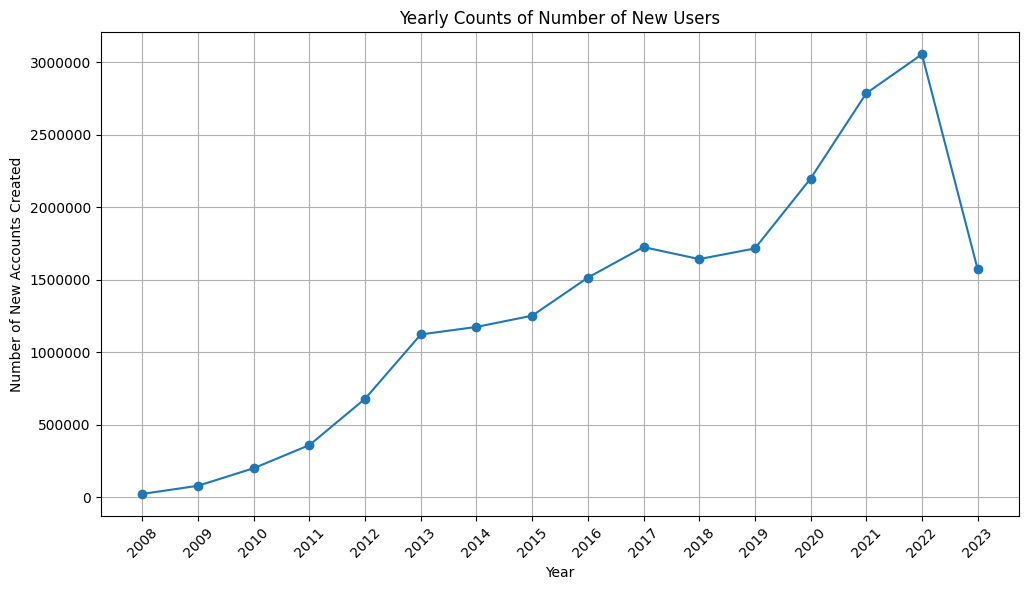

In [75]:
# Visualization of median value by each month.
import matplotlib.ticker as ticker
plt.figure(figsize=(10, 6))
plt.plot(NumNewUser['year'].astype(str), NumNewUser['owner_user_id'], marker='o', linestyle='-')
plt.title('Yearly Counts of Number of New Users')
plt.xlabel('Year')
plt.ylabel('Number of New Accounts Created')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x)))

# Display the plot
plt.show()

### Visualization: Number of Posts by User Registration Date (posts created between 21.08 ~ 23.09)
- or Number of Posts Created by Users based on their registration month.

In [3]:
import pandas as pd
df = pd.read_csv("df_isNew.csv")

In [4]:
df

,id,creation_date,owner_user_id,tags,account_creation_date,month_diff,year_month,isNew
0,69006423,2021-09-01 00:00:35.237,14087917,"[""node.js"", ""reactjs"", ""express"", ""axios"", ""re...",2020-08-11 15:14:12.437,12.845518,2021-09,0
1,69006426,2021-09-01 00:00:55.583,13091928,"[""r"", ""shiny""]",2020-03-20 01:17:22.550,17.664897,2021-09,0
2,69006431,2021-09-01 00:01:23.670,8110267,"[""java"", ""installation"", ""compilation"", ""proje...",2017-06-04 12:15:02.013,51.649684,2021-09,0
3,69006437,2021-09-01 00:03:18.750,2745485,"[""firebase"", ""nuxt.js"", ""firebase-hosting""]",2013-09-04 06:00:02.613,97.291742,2021-09,0
4,69006439,2021-09-01 00:03:36.930,12139975,"[""r"", ""data.table""]",2019-09-29 20:57:59.120,23.404297,2021-09,0
...,...,...,...,...,...,...,...,...
2682774,77019848,2023-08-31 23:54:30.057,1006272,"[""docker"", ""docker-compose"", ""owasp-dependency...",2011-10-21 00:44:45.587,144.432170,2023-08,0
2682775,77019849,2023-08-31 23:55:21.660,15216800,"[""microsoft-graph-api"", ""sharepoint-online""]",2021-02-15 22:29:56.837,30.901977,2023-08,0
2682776,77019852,2023-08-31 23:56:42.653,433202,"[""python"", ""numpy"", ""floating-point""]",2010-08-27 17:36:47.873,158.408794,2023-08,0
2682777,77019854,2023-08-31 23:57:28.633,2532775,"[""angular"", ""typescript"", ""progressive-web-app...",2013-06-28 17:18:15.807,123.875908,2023-08,0


In [5]:
df['account_year'] = pd.to_datetime(df['account_creation_date']).dt.to_period('Y') # Monthly

In [6]:
df

,id,creation_date,owner_user_id,tags,account_creation_date,month_diff,year_month,isNew,account_year
0,69006423,2021-09-01 00:00:35.237,14087917,"[""node.js"", ""reactjs"", ""express"", ""axios"", ""re...",2020-08-11 15:14:12.437,12.845518,2021-09,0,2020
1,69006426,2021-09-01 00:00:55.583,13091928,"[""r"", ""shiny""]",2020-03-20 01:17:22.550,17.664897,2021-09,0,2020
2,69006431,2021-09-01 00:01:23.670,8110267,"[""java"", ""installation"", ""compilation"", ""proje...",2017-06-04 12:15:02.013,51.649684,2021-09,0,2017
3,69006437,2021-09-01 00:03:18.750,2745485,"[""firebase"", ""nuxt.js"", ""firebase-hosting""]",2013-09-04 06:00:02.613,97.291742,2021-09,0,2013
4,69006439,2021-09-01 00:03:36.930,12139975,"[""r"", ""data.table""]",2019-09-29 20:57:59.120,23.404297,2021-09,0,2019
...,...,...,...,...,...,...,...,...,...
2682774,77019848,2023-08-31 23:54:30.057,1006272,"[""docker"", ""docker-compose"", ""owasp-dependency...",2011-10-21 00:44:45.587,144.432170,2023-08,0,2011
2682775,77019849,2023-08-31 23:55:21.660,15216800,"[""microsoft-graph-api"", ""sharepoint-online""]",2021-02-15 22:29:56.837,30.901977,2023-08,0,2021
2682776,77019852,2023-08-31 23:56:42.653,433202,"[""python"", ""numpy"", ""floating-point""]",2010-08-27 17:36:47.873,158.408794,2023-08,0,2010
2682777,77019854,2023-08-31 23:57:28.633,2532775,"[""angular"", ""typescript"", ""progressive-web-app...",2013-06-28 17:18:15.807,123.875908,2023-08,0,2013


In [10]:
df_vis = df.groupby('account_year')['id'].count().reset_index(name = 'count')
df_vis

,account_year,count
0,2008,7114
1,2009,24590
2,2010,43218
3,2011,75507
4,2012,103039
5,2013,116996
6,2014,109853
7,2015,116636
8,2016,124746
9,2017,141749


In [18]:
df_vis.describe()

,count
count,16.000000
mean,167673.687500
std,150569.508569
min,7114.000000
25%,96156.000000
50%,120871.000000
75%,186292.000000
max,567593.000000


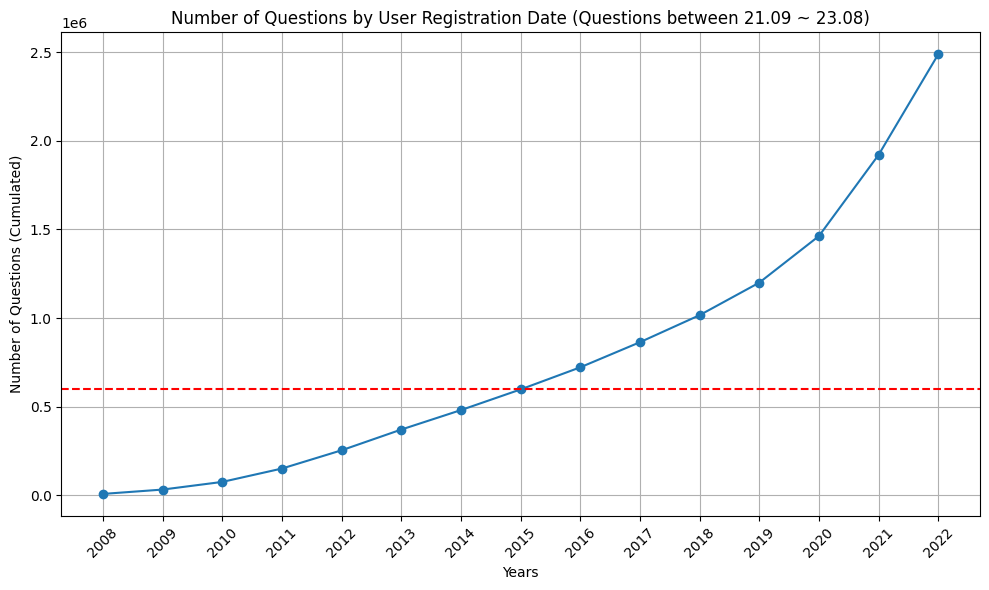

In [30]:
import matplotlib.pyplot as plt

# Erase the last year as it's truncated.
median_value = df_vis[:-1]['count'].cumsum().median()


plt.figure(figsize=(10, 6))
plt.plot(df_vis[:-1]['account_year'].astype(str), df_vis[:-1]['count'].cumsum(), marker='o', linestyle='-')
# Add a horizontal line at the median value
plt.axhline(y=median_value, color='r', linestyle='--', label=f'Median = {median_value}')
plt.title("Number of Questions by User Registration Date (Questions between 21.09 ~ 23.08)")
plt.xlabel("Years")
plt.ylabel("Number of Questions (Cumulated)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


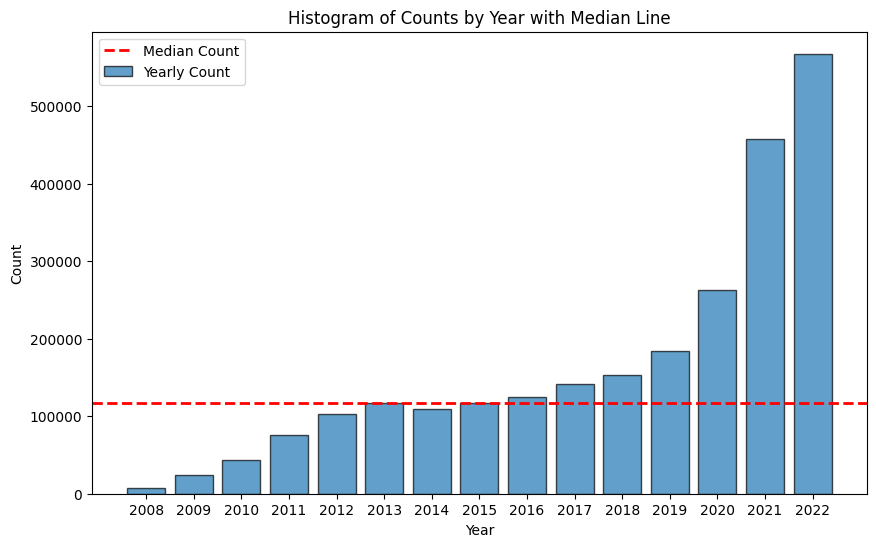

In [35]:
# Calculate median
import numpy as np
median_count = np.median(df_vis[:-1]['count'])
# Plot with the median line correctly positioned across the counts
plt.figure(figsize=(10, 6))
plt.bar(df_vis[:-1]['account_year'].astype(str), df_vis[:-1]['count'], edgecolor='black', alpha=0.7)
plt.axhline(median_count, color='r', linestyle='dashed', linewidth=2)
plt.title('Histogram of Counts by Year with Median Line')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(['Median Count', 'Yearly Count'])
plt.show()


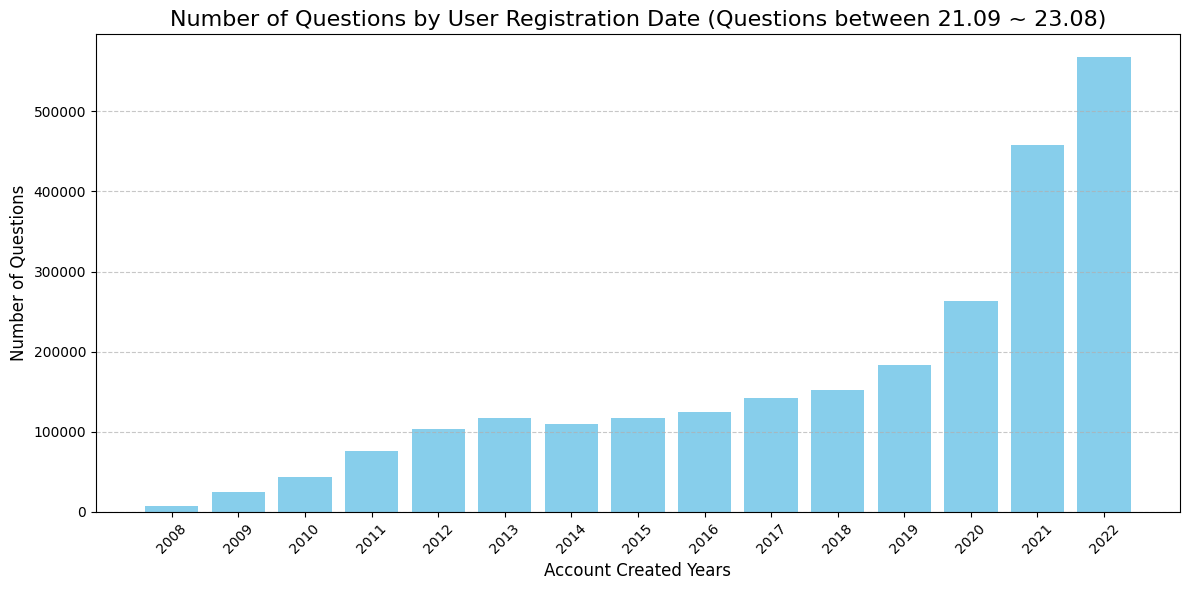

In [40]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame df with columns 'year_month' and 'post_count'
# df should be grouped by 'year_month' and summed over 'post_count'

plt.figure(figsize=(12, 6))
plt.bar(df_vis[:-1]['account_year'].astype(str), df_vis[:-1]['count'], color='skyblue')
plt.title("Number of Questions by User Registration Date (Questions between 21.09 ~ 23.08)", fontsize = 16)
plt.xlabel("Account Created Years", fontsize = 12)
plt.ylabel("Number of Questions", fontsize = 12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [23]:
df_vis[:-1]['count'].cumsum().describe()

count    1.500000e+01
mean     7.758371e+05
std      7.341743e+05
min      7.114000e+03
25%      2.019485e+05
50%      5.969530e+05
75%      1.107771e+06
max      2.488297e+06
Name: count, dtype: float64